###### <h1 style="color:Black" align="center">DENVER HOUSING PRICES EXPLORATION</h1>

## 1. INTRODUCTION

This kernel has 4 main parts: Data Handling, Exploratory Data Analysis, Feature Engineering and Model. We try to generate important features to have closer approach to Denver house data.

In [396]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objects as go
import plotly.express as px

import cufflinks as cf
cf.go_offline()

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/pirple/Data-Mining-With-Python/master/Part%202/single_family_home_values.csv')
df.sample(5)

,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
11346,9988345,2237 Cherry St,Denver,CO,80207,39.750041,-104.934250,3,2.0,6,2195,4500,1898.0,2013-09-26,568000,2006-08-26,483800.0,767282
9135,184287405,2601 Dexter St,Denver,CO,80207,39.754880,-104.933133,2,2.0,6,1537,5950,1926.0,2015-01-20,500000,2009-11-02,NaN,599349
10322,51295622,2929 Birch St,Denver,CO,80207,39.758921,-104.936417,2,2.0,5,1100,5700,1925.0,2000-10-06,199900,NaN,NaN,480055
4005,39849906,3001 N Vine St,Denver,CO,80205,39.759681,-104.962560,4,2.0,9,2366,6280,1909.0,2004-10-12,350000,NaN,NaN,626976
8242,184188808,901 Jackson St,Denver,CO,80206,39.730660,-104.943202,3,2.0,7,1699,5940,1910.0,2016-04-22,606500,2013-12-04,580000.0,716222


### Overview

With a glance at dataset, it has 18 columns and 15000 rows:
* `id`: is the unique id of the row and it doesn't affect the estimated value
* `address`: is the address of the house in Colorado State, Denver City, its unique values are 14988, it means that we have some duplicated data need to be handled
* `city`, `state`: is also the unique value in dataset as we know that we will study in Colorado State
* `zipcode`: stands for "Zone Improvement Plan", zipcode indicates the destination post office or delivery area serviced by the USPS. Colorado State have many zipcodes but we only focus on 10 zipcode dataset provided `80022`, `80033`, `80123`, `80202`, `80203`, `80204`, `80205`, `80206`, `80207`, `80209`
* `latitude`, `longitude`: is a geographic coordinate that specifies the north–south position of a point on the Earth's surface.
* `bedrooms`, `bathrooms`, `rooms`: are the detailed numbers of room in each real state
* `squareFootage`: is the square foot (sf or ft² denoted), is nearly equal to 929 cm² according to Google
* `lotSize`: is the size of the land of the property
* `yearBuilt`: is the time the property started buiding
* `lastSaleDate`, `lastSaleAmount`, `priorSaleDate`, `priorSaleAmount`: is the time and amount the property was on sale first and final time
* `estimated_value`: is the target amount of the property we try to predict

In [3]:
df.shape

(15000, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   address          15000 non-null  object 
 2   city             15000 non-null  object 
 3   state            15000 non-null  object 
 4   zipcode          15000 non-null  int64  
 5   latitude         14985 non-null  float64
 6   longitude        14985 non-null  float64
 7   bedrooms         15000 non-null  int64  
 8   bathrooms        15000 non-null  float64
 9   rooms            15000 non-null  int64  
 10  squareFootage    15000 non-null  int64  
 11  lotSize          15000 non-null  int64  
 12  yearBuilt        14999 non-null  float64
 13  lastSaleDate     15000 non-null  object 
 14  lastSaleAmount   15000 non-null  int64  
 15  priorSaleDate    11173 non-null  object 
 16  priorSaleAmount  11287 non-null  float64
 17  estimated_va

In [5]:
for i in df.columns:
    print(f'{i}: Number of unique value: {df[i].nunique()}')
    print(f'Detailed data: {df[i].unique()}')
    print()

id: Number of unique value: 15000
Detailed data: [ 39525749 184578398 184430015 ...  12995320  39611615  42961679]

address: Number of unique value: 14998
Detailed data: ['8171 E 84th Ave' '10556 Wheeling St' '3190 Wadsworth Blvd' ...
 '870 S Race St' '130 S Lafayette St' '100 S University Blvd # 1']

city: Number of unique value: 1
Detailed data: ['Denver']

state: Number of unique value: 1
Detailed data: ['CO']

zipcode: Number of unique value: 10
Detailed data: [80022 80033 80123 80202 80203 80204 80205 80206 80207 80209]

latitude: Number of unique value: 12345
Detailed data: [39.84916  39.88802  39.76171  ... 39.709681 39.700736 39.714088]

longitude: Number of unique value: 8973
Detailed data: [-104.893468 -104.83093  -105.08107  ... -104.951719 -104.976608
 -104.986   ]

bedrooms: Number of unique value: 13
Detailed data: [ 3  2  4  5  1  7  6  8 10  9  0 13 15]

bathrooms: Number of unique value: 15
Detailed data: [ 2.   1.   3.   4.   5.   6.   7.   8.   0.5  0.   9.  11.   1.

## 2. DATA HANDLING

We have to fill in missing value and have a look on the invalid data to handle. From the dataset, we can see:
* Missing Value: `latitude`, `longitude`, `yearBuilt`, `priorSaleDate`, `priorSaleAmount`
* Invalid data: 
    - `address`: 14988 unique data which mean it has duplicated data
    - `bedrooms`, `bathrooms`, `rooms`: need to take a look on 0 data and other outliers
    - `priorSaleDate` must be smaller than `lastSaleDate`

In [6]:
df.isna().sum()

id                    0
address               0
city                  0
state                 0
zipcode               0
latitude             15
longitude            15
bedrooms              0
bathrooms             0
rooms                 0
squareFootage         0
lotSize               0
yearBuilt             1
lastSaleDate          0
lastSaleAmount        0
priorSaleDate      3827
priorSaleAmount    3713
estimated_value       0
dtype: int64

### 2.1 Latitude & Longitude

The latitude and longitude feature both have 15 missing value at the same 15 id. We can find the actual longitude and latidue in real world based on the provided address feature by searching it on google maps to take the coordinates. We try to make sure the real data.

In [7]:
df[(df['latitude'].isna())]

,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
198,24536341,944 N Lincoln St,Denver,CO,80203,NaN,NaN,1,1.0,4,1032,3140,1896.0,2015-10-29,1400000,1997-08-21,150000.0,473990
450,24536342,950 N Lincoln St,Denver,CO,80203,NaN,NaN,3,2.0,10,2740,3140,1910.0,2015-10-29,1400000,1991-11-21,74100.0,716696
452,140073812,71 N Pennsylvania St,Denver,CO,80203,NaN,NaN,2,1.0,5,950,4690,1895.0,2016-01-21,330000,1995-05-26,NaN,466582
549,205474028,1071 N Washington St,Denver,CO,80203,NaN,NaN,1,1.0,4,750,1013,1888.0,2012-11-26,203000,2008-11-19,161000.0,350965
757,39540559,1823 Hooker St # 3,Denver,CO,80204,NaN,NaN,3,2.0,5,1300,7000,1955.0,2015-12-21,465000,2015-12-01,419000.0,540293
2451,25727750,803 Mariposa St,Denver,CO,80204,NaN,NaN,2,2.0,7,4025,3132,1913.0,2002-03-12,279000,2000-09-12,215000.0,632213
3274,320948074,3650 N Adams St,Denver,CO,80205,NaN,NaN,4,4.0,7,2826,4690,2016.0,2017-05-23,735000,NaN,NaN,745537
3870,184192336,2134 N Williams St,Denver,CO,80205,NaN,NaN,4,1.0,8,2100,10940,1893.0,2011-10-12,306800,NaN,NaN,719222
3928,253167748,3346 N Williams St,Denver,CO,80205,NaN,NaN,3,3.0,6,1848,3125,2016.0,2016-09-30,55200,NaN,NaN,577147
4762,248507008,3118 N Vine St,Denver,CO,80205,NaN,NaN,4,4.0,8,1908,4685,2012.0,2013-02-21,425000,NaN,NaN,670436


In [8]:
coordinate_inf = {
    '944 N Lincoln St':[39.731355, -104.985755],
    '950 N Lincoln St': [39.73146, -104.985754],
    '71 N Pennsylvania St': [39.717837, -104.981729],
    '1071 N Washington St': [39.733326, -104.978951],
    '1823 Hooker St # 3': [39.745763, -105.028805],
    '803 Mariposa St': [39.729062, -105.003218],
    '3650 N Adams St': [39.767888, -104.948367],
    '2134 N Williams St': [39.748849, -104.965623],
    '3346 N Williams St': [39.764217, -104.965722],
    '3118 N Vine St': [39.761214, -104.961873],
    '3308 N High St': [39.763524, -104.964382],
    '2760 N Columbine St': [39.756818, -104.957107],
    '3154 N York St': [39.761713, -104.959413],
    '3650 N Adams St':[39.767888, -104.948367],
    '402 Harrison St': [39.722717, -104.941101],
}
for i in df.loc[df['latitude'].isna()].address:
    df.loc[df['address']==i,['latitude']] = coordinate_inf[i][0]
    df.loc[df['address']==i,['longitude']] = coordinate_inf[i][1]

In [9]:
print(df['latitude'].isna().sum())
print(df['longitude'].isna().sum())

0
0


### 2.2 yearBuilt

yearBuilt is the most easy feature to fill in dataset as it only has 1 missing value, also we can find the actual year on zillow page when searching for the provided address 1256 Columbine St. To make sure, we can compare the zipcode number 80206. 

In the zillow web page: https://www.zillow.com/b/1256-columbine-st-denver-co-5XxZdx/ , roll down to Face & Feature, we can find the Built in 1911 information.

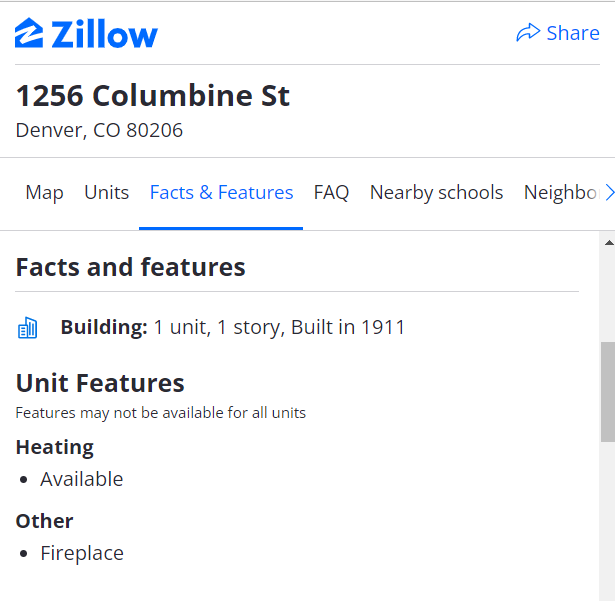

In [10]:
df[df['yearBuilt'].isna()]

,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
9068,184292071,1256 Columbine St,Denver,CO,80206,39.73625,-104.95714,5,5.0,13,3068,278,NaN,2017-05-11,400000,2012-04-04,132500.0,264843


In [11]:
df['yearBuilt'] = df['yearBuilt'].fillna(1911)
df['yearBuilt'].isna().sum()

0

### 2.3 Address

The address feature has 2 duplicated value in `3118 N Vine St`, `3650 N Adams St`, we will focus on the number of rooms and the area, sale amount feature which affect on target value and the `estimated_value`:
* `3118 N Vine St`: 2 duplicated data is the same except the estimated value house price is different around 1000USD, it is not much in the range of data 9997543USD, so I decide to keep the latest one which is keep the last
* `3650 N Adams St`: 2 duplicated data is different in the important variables (rooms, area, year, amount), it can be the 2 distinct properties or the same property but reconstruct the second time (the yearBuilt is far from each other, the first one in 1926 and the second one is in the 2012). If they are 2 different properties, we cannot find more data to keep the data as address, zipcode, latitude and longitude are similar. There is no way but to clean out 1 data. After searching on Zillow (https://www.zillow.com/homes/3650-N-Adams-St_rb/13302705_zpid/), it is 4 bedrooms and 4 bathrooms so I decide to keep this one which is keep tthe first
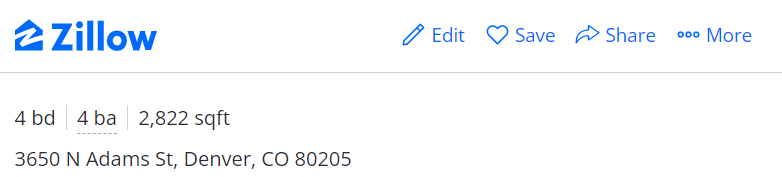

In [12]:
range_estimated_value = df['estimated_value'].max() - df['estimated_value'].min()
print(f'The range of estimated value: {range_estimated_value}')
df[df.duplicated(subset=['address']) == True]

The range of estimated value: 9997543


,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
4764,216346608,3118 N Vine St,Denver,CO,80205,39.761214,-104.961873,4,4.0,8,1908,4685,2012.0,2013-02-21,425000,NaN,NaN,671744
6145,4277764,3650 N Adams St,Denver,CO,80205,39.767888,-104.948367,1,1.0,3,472,9370,1926.0,2015-07-20,250000,NaN,NaN,745483


In [13]:
df[df['address'] == '3118 N Vine St']

,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
4762,248507008,3118 N Vine St,Denver,CO,80205,39.761214,-104.961873,4,4.0,8,1908,4685,2012.0,2013-02-21,425000,NaN,NaN,670436
4764,216346608,3118 N Vine St,Denver,CO,80205,39.761214,-104.961873,4,4.0,8,1908,4685,2012.0,2013-02-21,425000,NaN,NaN,671744


In [14]:
df[df['address'] == '3650 N Adams St']

,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
3274,320948074,3650 N Adams St,Denver,CO,80205,39.767888,-104.948367,4,4.0,7,2826,4690,2016.0,2017-05-23,735000,NaN,NaN,745537
6145,4277764,3650 N Adams St,Denver,CO,80205,39.767888,-104.948367,1,1.0,3,472,9370,1926.0,2015-07-20,250000,NaN,NaN,745483


In [15]:
print(f'The length of our dataframe: {len(df)}')
print(f'The number of unique value in address columns: {df.address.nunique()}')

The length of our dataframe: 15000
The number of unique value in address columns: 14998


In [16]:
df.drop(df.index[[4762,6145]], inplace=True)

In [17]:
print(f'The length of our dataframe: {len(df)}')
print(f'The number of unique value in address columns: {df.address.nunique()}')

The length of our dataframe: 14998
The number of unique value in address columns: 14998


### 2.4 Bedrooms, Bathrooms and Rooms

There are some invalid values need to take a look:
* `Bedrooms`: the data have 13 unique value, which is densly focus on 1 to 6. The total numbers of our dataset is 14998 (after cleaning the address), I decide to clean out the number of rooms which is more than 9 (3 data: not affecting much to the dataset) to decrease the skewness and imbalance in data which is better for predicting model. The 0 data is also re-verified on Zillow
    - `745 Irving St`: 3 beds, 1 bath
    - `625 Newton St`: 1 bed, 1 bath
    - `159 Madison St`: I decide to clean out this data as the number of bedrooms, bathrooms & rooms all 0
* `Bathrooms`: the data have 15 unique value, somehow the same with `bedrooms`, is also densely focus from 1 to 5. However bathrooms feature has float data which is unlogical as rooms in real life is discrete numeric data. To decrease the skewness, I decide to clean out outliers (10, 11, 12) and change the float data. For the 0 one, I re-verified it on Zillow:
    - `938 Inca St`: 2 beds, 1 bath
    - `926 Mariposa St`: 2 beds, 1 bath
    - `2342 N Clarkson St`: 5 beds, 4 bath
    - `3418 N Lafayette St`: 2 beds, 2 bath
    - `636 27th St`: 2 beds, 2 bath
    - `3510 N Marion St`: 2 beds, 1 bath
* `Rooms`: 25 unique value which ranges from 0 to 30 after cleaning the invalid address, bedrooms and bathrooms. Similarly, I will clean out the outliers values (rooms > 20). To fill the 0 data in room feature, we cannot base on information on Zillow, so I decide to choose the highest frequency of rooms feature with the same bedrooms and bathrooms:
    - 3 bedrooms, 1 bathroom: 6 rooms
    - 3 bedrooms, 3 bathrooms: 7 rooms
    - 4 bedrooms, 3 bathrooms: 8 rooms

In [18]:
print(f'Number of unique bedsroom: {df.bedrooms.nunique()}')
print(f'Number of unique bathsroom: {df.bathrooms.nunique()}')
print(f'Number of unique room: {df.rooms.nunique()}')

Number of unique bedsroom: 13
Number of unique bathsroom: 15
Number of unique room: 25


**2.4.1 Bedrooms**

In [19]:
df_bedrooms = df['bedrooms'].value_counts().to_frame()
df_bedrooms.unstack()

bedrooms  2     6635
          3     5669
          4     1841
          1      372
          5      346
          6       84
          7       30
          8        9
          9        6
          0        3
          10       1
          13       1
          15       1
dtype: int64

In [20]:
df = df[(df['bedrooms']!=10)&(df['bedrooms']!=13)&(df['bedrooms']!=15)]
df.reset_index()
print(f'The length of our dataframe: {len(df)}')

The length of our dataframe: 14995


In [21]:
df[(df['bedrooms']==0)]

,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
1396,1534157,745 Irving St,Denver,CO,80204,39.728603,-105.030410,0,1.0,4,595,6260,1951.0,2007-10-07,64900,2007-05-10,0.0,262310
1538,3858650,625 Newton St,Denver,CO,80204,39.726646,-105.037598,0,1.0,2,350,5960,1924.0,2017-02-07,100000,2002-08-01,65000.0,241357
7178,184300300,159 Madison St,Denver,CO,80206,39.719009,-104.946513,0,0.0,0,1584,5250,1974.0,2015-03-18,1650000,2011-12-01,710000.0,355357


In [22]:
df.loc[df['address']=='745 Irving St',['bedrooms']] = 3
df.loc[df['address']=='625 Newton St',['bedrooms']] = 1
df = df[(df['bedrooms']!=0)]
df.reset_index()
df.head(3)

,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
0,39525749,8171 E 84th Ave,Denver,CO,80022,39.84916,-104.893468,3,2.0,6,1378,9968,2003.0,2009-12-17,75000,2004-05-13,165700.0,239753
1,184578398,10556 Wheeling St,Denver,CO,80022,39.88802,-104.830930,2,2.0,6,1653,6970,2004.0,2004-09-23,216935,NaN,NaN,343963
2,184430015,3190 Wadsworth Blvd,Denver,CO,80033,39.76171,-105.081070,3,1.0,0,1882,23875,1917.0,2008-04-03,330000,NaN,NaN,488840


In [23]:
fig = px.histogram(df['bedrooms'], nbins=10,
                title='The Distribution of Number of Bedrooms in CO States', color_discrete_sequence=["#6D0E21"])
fig.update_layout(xaxis_title_text='Number of Bedrooms', yaxis_title_text='Total Count Values', bargap=0.2,
                 xaxis = dict(showgrid=False, showticklabels=True, showline=True,
                              linewidth=2, linecolor='#6D0E21',ticks='outside',
                              tickfont=dict(family='Arial',size=12,color='#6D0E21')),
                  yaxis = dict(showgrid=False, showticklabels=True, showline=True,
                              linewidth=2, linecolor='#6D0E21',ticks='outside',
                              tickfont=dict(family='Arial',size=12,color='#6D0E21')),
                 plot_bgcolor='white',showlegend=False, autosize=False,)

In [24]:
print(f'The length of our dataframe: {len(df)}')
print(f'Number of unique bedrooms: {df.bedrooms.nunique()}')
print(f'Detailed unique bedrooms: {df.bedrooms.unique()}')

The length of our dataframe: 14994
Number of unique bedrooms: 9
Detailed unique bedrooms: [3 2 4 5 1 7 6 8 9]


**2.4.2 Bathrooms**

With bathrooms, we need to handle the float data (0.5 & 1.5):
* 0.5: at least in one property will have 1 bathroom, there is nonsense with fill in 0. The number of 0.5 bathrooms are 9, we will replace it by 1
* 1.5: we have 1 data with 1.5 bathrooms, it has 4 bedrooms and 6 rooms. The same data 4 bedrooms and 6 rooms give us with the median bathrooms feature is 2, so we will fill in 2

In [25]:
print(f'Number of 0.5 bathrooms: {len(df[df.bathrooms==0.5])}')
print(f'Number of 0.5 bathrooms: {len(df[df.bathrooms==1.5])}')

Number of 0.5 bathrooms: 9
Number of 0.5 bathrooms: 1


In [26]:
df_bathrooms = df['bathrooms'].value_counts().to_frame()
df_bathrooms.unstack()

bathrooms  2.0     6575
           1.0     4201
           3.0     2367
           4.0     1165
           5.0      413
           6.0      151
           7.0       57
           8.0       37
           9.0        9
           0.5        9
           0.0        6
           1.5        1
           11.0       1
           10.0       1
           12.0       1
dtype: int64

In [27]:
df = df[(df['bathrooms']!=10)&(df['bathrooms']!=11)&(df['bathrooms']!=12)]
df.reset_index()
print(f'The length of our dataframe: {len(df)}')

The length of our dataframe: 14991


In [28]:
df[(df['bathrooms']==0)]

,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
1651,15920561,938 Inca St,Denver,CO,80204,39.731327,-104.997166,1,0.0,4,620,2111,1915.0,2017-06-06,690000,2005-02-24,255000.0,335907
2786,144046340,926 Mariposa St,Denver,CO,80204,39.731060,-105.002456,2,0.0,4,729,3130,1888.0,1998-12-23,165500,NaN,NaN,342608
3840,251007587,2342 N Clarkson St,Denver,CO,80205,39.751381,-104.976933,3,0.0,6,2098,3125,2016.0,2017-05-18,895000,2016-02-01,48000.0,889990
5933,3548633,3418 N Lafayette St,Denver,CO,80205,39.764945,-104.970538,2,0.0,5,714,4700,1892.0,2017-06-21,345000,1994-07-01,28000.0,354576
6552,46169077,636 27th St,Denver,CO,80205,39.755234,-104.978980,2,0.0,5,757,2065,1893.0,2002-01-30,77000,NaN,NaN,344748
6625,1826069,3510 N Marion St,Denver,CO,80205,39.766026,-104.971761,1,0.0,3,506,2500,1886.0,2007-11-06,42200,2007-08-09,96482.0,333325


In [29]:
df.loc[df['address']=='938 Inca St',['bathrooms']] = 1
df.loc[df['address']=='926 Mariposa St',['bathrooms']] = 1
df.loc[df['address']=='2342 N Clarkson St',['bathrooms']] = 4
df.loc[df['address']=='3418 N Lafayette St',['bathrooms']] = 2
df.loc[df['address']=='636 27th St',['bathrooms']] = 2
df.loc[df['address']=='3510 N Marion St',['bathrooms']] = 1
df = df[(df['bathrooms']!=0)]
df.reset_index()
df.head(3)

,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
0,39525749,8171 E 84th Ave,Denver,CO,80022,39.84916,-104.893468,3,2.0,6,1378,9968,2003.0,2009-12-17,75000,2004-05-13,165700.0,239753
1,184578398,10556 Wheeling St,Denver,CO,80022,39.88802,-104.830930,2,2.0,6,1653,6970,2004.0,2004-09-23,216935,NaN,NaN,343963
2,184430015,3190 Wadsworth Blvd,Denver,CO,80033,39.76171,-105.081070,3,1.0,0,1882,23875,1917.0,2008-04-03,330000,NaN,NaN,488840


In [30]:
df[df['bathrooms']==1.5]

,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
6044,216448725,2071 N Colorado Blvd # 58,Denver,CO,80205,39.748706,-104.940803,4,1.5,6,2256,108900,1945.0,2000-09-14,340000,NaN,NaN,349664


In [31]:
df.loc[(df['bedrooms']==4)&(df['rooms']==6),['bathrooms']].median()

bathrooms    2.0
dtype: float64

In [32]:
df['bathrooms'] = df['bathrooms'].replace({0.5:1,1.5:2})

In [33]:
fig = px.histogram(df['bathrooms'], nbins=10,
                title='The Distribution of Number of Bathrooms in CO States', color_discrete_sequence=["#6D0E21"])
fig.update_layout(xaxis_title_text='Number of Bathrooms', yaxis_title_text='Total Count Values', bargap=0.2,
                 xaxis = dict(showgrid=False, showticklabels=True, showline=True,
                              linewidth=2, linecolor='#6D0E21',ticks='outside',
                              tickfont=dict(family='Arial',size=12,color='#6D0E21')),
                  yaxis = dict(showgrid=False, showticklabels=True, showline=True,
                              linewidth=2, linecolor='#6D0E21',ticks='outside',
                              tickfont=dict(family='Arial',size=12,color='#6D0E21')),
                 plot_bgcolor='white',showlegend=False, autosize=False)

In [34]:
df['bathrooms'] = df['bathrooms'].astype(int)

In [35]:
print(f'The length of our dataframe: {len(df)}')
print(f'Number of unique bathrooms: {df.bathrooms.nunique()}')
print(f'Detailed unique bathrooms: {df.bathrooms.unique()}')

The length of our dataframe: 14991
Number of unique bathrooms: 9
Detailed unique bathrooms: [2 1 3 4 5 6 7 8 9]


**2.4.3 Rooms**

In [36]:
df_rooms = df['rooms'].value_counts().to_frame()
df_rooms.unstack()

rooms  5     4350
       6     3419
       7     2175
       4     2115
       8     1318
       9      691
       10     360
       11     164
       12     116
       3      103
       13      53
       14      41
       15      33
       16      19
       0        8
       18       7
       20       4
       2        4
       17       4
       21       3
       22       2
       28       1
       30       1
dtype: int64

In [37]:
df = df[(df['rooms']!=21)&(df['rooms']!=22)&(df['rooms']!=28)&(df['rooms']!=30)]
df.reset_index()
print(f'The length of our dataframe: {len(df)}')

The length of our dataframe: 14984


In [38]:
df[(df['rooms']==0)].sort_values(by='bedrooms')

,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
2,184430015,3190 Wadsworth Blvd,Denver,CO,80033,39.76171,-105.08107,3,1,0,1882,23875,1917.0,2008-04-03,330000,NaN,NaN,488840
9,184623176,4967 S Wadsworth Blvd,Denver,CO,80123,39.62677,-105.08199,3,3,0,2054,4050,2007.0,2015-12-01,407000,2012-10-30,312000.0,424514
98,184623175,4957 S Wadsworth Blvd,Denver,CO,80123,39.62690,-105.08199,3,3,0,1925,4050,2007.0,2013-11-19,328000,2009-01-13,267000.0,417243
100,184623177,4977 S Wadsworth Blvd,Denver,CO,80123,39.62665,-105.08199,3,3,0,1925,4050,2007.0,2007-02-21,306249,NaN,NaN,414342
102,184623174,4947 S Wadsworth Blvd,Denver,CO,80123,39.62703,-105.08199,3,3,0,2445,4410,2007.0,2015-12-24,405000,2015-06-25,325000.0,461609
3,155129946,3040 Wadsworth Blvd,Denver,CO,80033,39.76078,-105.08106,4,3,0,2400,11500,1956.0,2008-12-02,185000,2008-06-27,0.0,494073
101,184623178,4997 S Wadsworth Blvd,Denver,CO,80123,39.62639,-105.08200,4,3,0,2445,4050,2007.0,2017-04-03,450000,2013-08-08,355000.0,461230
143,30780429,4987 S Wadsworth Blvd,Denver,CO,80123,39.62652,-105.08200,4,3,0,2236,4050,2007.0,2016-05-23,417500,2012-10-25,330000.0,453661


In [39]:
bd3_ba1 = df.loc[(df['bedrooms']==3) & (df['bathrooms']==1),['rooms']].median()
bd4_ba3 = df.loc[(df['bedrooms']==4) & (df['bathrooms']==3),['rooms']].median()
bd3_ba3 = df.loc[(df['bedrooms']==3) & (df['bathrooms']==3),['rooms']].median()

In [40]:
df.loc[2,['rooms']] = bd3_ba1
for i in [9,98,100,102]:
    df.loc[i,['rooms']] = bd3_ba3
for i in [3,101,143]:
    df.loc[i,['rooms']] = bd4_ba3

In [41]:
fig = px.histogram(df['rooms'], nbins=10,
                title='The Distribution of Number of rooms in CO States', color_discrete_sequence=["#6D0E21"])
fig.update_layout(xaxis_title_text='Number of rooms', yaxis_title_text='Total Count Values', bargap=0.2,
                 xaxis = dict(showgrid=False, showticklabels=True, showline=True,
                              linewidth=2, linecolor='#6D0E21',ticks='outside',
                              tickfont=dict(family='Arial',size=12,color='#6D0E21')),
                  yaxis = dict(showgrid=False, showticklabels=True, showline=True,
                              linewidth=2, linecolor='#6D0E21',ticks='outside',
                              tickfont=dict(family='Arial',size=12,color='#6D0E21')),
                 plot_bgcolor='white',showlegend=False, autosize=False)

In [42]:
df['rooms'] = df['rooms'].astype(int)

In [43]:
print(f'The length of our dataframe: {len(df)}')
print(f'Number of unique rooms: {df.rooms.nunique()}')
print(f'Detailed unique rooms: {df.rooms.unique()}')

The length of our dataframe: 14984
Number of unique rooms: 18
Detailed unique rooms: [ 6  8  7  4  9  5 10 17 11 13 12 15 14  2 18 16 20  3]


### 2.5 PriorSaleDate & LastSaleDate

A look at our dataset clearly appear that the most crucial missing data which affect most to our results is `priorSaleDate` (3821 missing values), `priorSaleAmount`(3708 missing values). These two features are inextricably linked together, and also have a close relationship with `lastSaleDate`, `lastSaleAmount`, so we will analyze these features together.

However, we must first clean out the invalid `lastSaleDate` < `priorSaleDate`

In [44]:
df[df['lastSaleDate'] < df['priorSaleDate']]

,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
520,51138584,14 N Pearl St,Denver,CO,80203,39.716824,-104.979979,1,2,5,2267,3994,1895.0,2000-07-13,267500,2004-05-11,47500.0,560032


In [45]:
df = df[df['id'] != 51138584]

In [46]:
print(f'The length of our dataframe: {len(df)}')

The length of our dataframe: 14983


**2.5.1 Overview**

A glance a simple statistic table, it reveals 2 problems in `priorSaleAmount`:
* Why `priorSaleAmount` is equal to 0? There are 1296 properties have 0 value in `priorSaleAmount` according to the dataset
* Why `priorSaleAmount` is N/A? Is there any relationships with the 0 in `priorSaleAmount`? There are 3708 properties have N/A value in `priorSaleAmount` according to the dataset

It can be concluded that the missing value in these 2 features is large, especially, the `priorSaleAmount` total 5004 (1296 + 3708) which is occupied more than 1/3 of our dataset. To respect to the origin data, we will try to explain these problems base on the existing `priorSaleAmount`, `priorSaleDate` data and its relationships with the remain features to find solution

In [47]:
df['priorSaleDate'] = pd.to_datetime(df['priorSaleDate'])
df['lastSaleDate'] = pd.to_datetime(df['lastSaleDate'])

In [48]:
df[['priorSaleAmount','lastSaleAmount']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
priorSaleAmount,11275.0,258678.901109,334816.053594,0.0,110000.0,209900.0,330000.0,16000000.0
lastSaleAmount,14983.0,405093.875726,776000.072297,259.0,194000.0,319900.0,462875.0,45600000.0


In [49]:
df[['priorSaleDate','lastSaleDate']].describe().transpose()

,count,unique,top,freq,first,last
priorSaleDate,11162,4474,2008-01-03,15,1967-05-10,2017-07-11
lastSaleDate,14983,4347,2014-03-03,19,1997-08-01,2017-07-21


In [50]:
print(f'Zero value in priorSaleAmount: {df[df.priorSaleAmount==0].shape[0]}')
print(f'N/A value in priorSaleAmount: {df[df.priorSaleAmount.isna()].shape[0]}')
print(f'N/A value in priorSaleDate: {df[df.priorSaleDate.isna()].shape[0]}')

Zero value in priorSaleAmount: 1296
N/A value in priorSaleAmount: 3708
N/A value in priorSaleDate: 3821


**2.5.2 Create the Time and Period of Date**

Firstly, I try to find out the gap between the `priorSaleDate` and `lastSaleDate`, I do believe that some plots of land sold at the short and long time between prior sale and last sale will have a difference in prices about the gap between the `priorSaleAmount` and `lastSaleAmount`. To record this, I create 2 new feature columns `time` which is value after calculating and `period`  which set 5 periods of gap between selling time:
* `VeryShort` (quantile of `time` < 0.1): include 1117 dataset ranging from 0 to 120 days with the average amount increase in sale is ...
* `Short` (quantile of `time` < 0.3): include 2232 dataset ranging from 120 to 393 days with the average amount increase in sale is ...
* `Medium` (quantile of `time` < 0.7): include 4464 dataset ranging from 393 to 2250 days with the average amount increase in sale is ...
* `Long` (quantile of `time` <  0.9): include 2231 dataset ranging from 2250 to 4382 days with the average amount increase in sale is ...
* `VeryLong` (the left values): include 1117 dataset ranging from 4382 to 18207 days with the average amount increase in sale is ...

In [51]:
prior_last_df = df[['priorSaleDate','lastSaleDate','priorSaleAmount','lastSaleAmount']]
prior_last_df.sample(4)

,priorSaleDate,lastSaleDate,priorSaleAmount,lastSaleAmount
13070,2003-10-14,2006-03-07,250000.0,1054000
6252,1995-10-05,2017-05-18,64500.0,403000
12243,2015-06-05,2015-08-28,305000.0,315000
6450,2007-05-03,2008-08-05,0.0,83000


In [52]:
prior_last_df['time'] = df['lastSaleDate'] - df['priorSaleDate']
prior_last_df.sample(4)

,priorSaleDate,lastSaleDate,priorSaleAmount,lastSaleAmount,time
7246,1999-12-09,2005-08-07,288000.0,377000,2068 days
8067,1999-09-07,2003-10-22,1280000.0,1432500,1506 days
11869,NaT,2005-08-04,NaN,620000,NaT
13373,NaT,2009-08-18,NaN,1750000,NaT


In [53]:
prior_last_df[['time']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
time,11162,1910 days 09:59:45.808994784,2303 days 23:13:25.117711232,0 days,281 days,1204 days 12:00:00,2596 days 18:00:00,18207 days


In [54]:
print(f'{prior_last_df.time.min()}')
print(f'{prior_last_df.time.quantile(0.1)}')
print(f'{prior_last_df.time.quantile(0.3)}')
print(f'{prior_last_df.time.quantile(0.7)}')
print(f'{prior_last_df.time.quantile(0.9)}')
print(f'{prior_last_df.time.max()}')

0 days 00:00:00
120 days 02:24:00.000000012
393 days 07:11:59.999999976
2250 days 16:48:00
4382 days 00:00:00
18207 days 00:00:00


In [55]:
prior_last_df['period'] = 0
periods = [['VeryShort', prior_last_df.time.min()], 
           ['Short', prior_last_df.time.quantile(0.1)], 
           ['Medium', prior_last_df.time.quantile(0.3)],
           ['Long', prior_last_df.time.quantile(0.7)], 
           ['VeryLong', prior_last_df.time.quantile(0.9)], 
           ['tempt', prior_last_df.time.max()]]
for i in prior_last_df.index:
    for j in range(0,5):
        if (prior_last_df['time'][i] >= periods[j][1]) and (prior_last_df['time'][i] < periods[j+1][1]):
            prior_last_df['period'][i] = periods[j][0]

In [56]:
prior_last_df.sample(5)

,priorSaleDate,lastSaleDate,priorSaleAmount,lastSaleAmount,time,period
6050,2010-07-12,2010-10-20,0.0,54900,100 days,VeryShort
12765,2001-11-06,2007-07-06,161900.0,140000,2068 days,Medium
3381,2015-08-06,2016-01-22,251000.0,326000,169 days,Short
6447,2010-12-10,2011-03-17,110500.0,193850,97 days,VeryShort
10691,2010-08-12,2011-05-24,79450.0,75000,285 days,Short


In [57]:
prior_last_df['period'].value_counts()

Medium       4464
0            3822
Short        2232
Long         2231
VeryShort    1117
VeryLong     1117
Name: period, dtype: int64

In [58]:
print(f"The average time spend in VeryShort stage: {prior_last_df.loc[prior_last_df.period=='VeryShort',['time']].mean()}")
print(f"The average time spend in Short stage: {prior_last_df.loc[prior_last_df.period=='Short',['time']].mean()}")
print(f"The average time spend in Medium stage: {prior_last_df.loc[prior_last_df.period=='Medium',['time']].mean()}")
print(f"The average time spend in Long stage: {prior_last_df.loc[prior_last_df.period=='Long',['time']].mean()}")
print(f"The average time spend in VeryLong stage: {prior_last_df.loc[prior_last_df.period=='VeryLong',['time']].mean()}")

The average time spend in VeryShort stage: time   61 days 17:30:40.286481647
dtype: timedelta64[ns]
The average time spend in Short stage: time   224 days 19:18:42.580645160
dtype: timedelta64[ns]
The average time spend in Medium stage: time   1250 days 05:46:46.451612896
dtype: timedelta64[ns]
The average time spend in Long stage: time   3107 days 10:59:00.295831456
dtype: timedelta64[ns]
The average time spend in VeryLong stage: time   7360 days 04:34:35.559534464
dtype: timedelta64[ns]


**2.5.3 Create the upAmount**

There are incorrect values in `lastSaleAmount`, (3 amounts) which are too large make data heavily impacted. I decide to remove all of it

After break down the data, we notice about the 0 in `time` feature. In real life, in order to sell a property, we need a certain time to prepare the selling process with relevant documents, so it is illogical that 2 sales in one day with 1 different amounts and 154 same amounts (155 data). 

It is possible that such prior sales never happened and rather represent a stage in the process of the last sale. Therefore, I assume that these properties only have lastSale, it also explains why some data we only have lastSale value and all priorSale is N/A.

So how can we fill it?
* `priorSaleDate` = `lastSaleDate`: set prior and last amount the same (155 one sale values)
* N/A `priorSaleDate` with N/A `priorSaleAmount`: I will assume it only has one sale, so I set the prior similar to the last in both sales and amount, it is reasonable base on 154 data above (3618 one sale values)
* N/A `priorSaleDate` but not N/A in `priorSaleAmount`: if the amount have not changed and no date, same case with above because we cannot retreive date data (201 one sale values)
* not N/A `priorSaleDate` but 0 in `priorSaleAmount`: base on the period of it, I will fill in the average amount of each period, total 1296 values (2 sales)
* not N/A `priorSaleDate` but N/A in `priorSaleAmount`: the same with the case above, 88 values (2 sales)

In [59]:
df[df['lastSaleAmount']==df['lastSaleAmount'].max()]

,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value
2220,18197590,1350 Osceola St,Denver,CO,80204,39.737493,-105.037811,2,1,6,929,4690,1914.0,2007-01-19,45600000,2002-07-01,157000.0,402561
2473,18197589,1320 Osceola St,Denver,CO,80204,39.737062,-105.037810,2,1,4,700,6250,1953.0,2007-01-19,45600000,NaT,NaN,306400
2971,18197588,1330 Osceola St,Denver,CO,80204,39.737183,-105.037810,2,1,5,1262,4690,1907.0,2007-01-19,45600000,NaT,NaN,397880


*Remove incorrect `lastSaleAmount`*

In [60]:
df = df[df['lastSaleAmount']!=45600000]
prior_last_df = prior_last_df[prior_last_df['lastSaleAmount']!=45600000]
print(f'The length of our dataframe: {len(df)}')
print(f'The length of our prior_last_df: {len(prior_last_df)}')
print(f'Last Sale Amount range: {df.lastSaleAmount.max() - df.lastSaleAmount.min()}')

The length of our dataframe: 14980
The length of our prior_last_df: 14980
Last Sale Amount range: 20999741


*Create `upAmount` column*

In [61]:
prior_last_df['upAmount'] = prior_last_df['lastSaleAmount'] - prior_last_df['priorSaleAmount']
print(prior_last_df.shape)
prior_last_df.sample(5)

(14980, 7)


,priorSaleDate,lastSaleDate,priorSaleAmount,lastSaleAmount,time,period,upAmount
13691,2009-08-14,2016-10-26,509000.0,748130,2630 days,Long,239130.0
12664,NaT,1997-08-14,NaN,77000,NaT,0,NaN
10621,2015-03-19,2016-02-25,280000.0,410000,343 days,Short,130000.0
3602,2009-10-21,2017-05-05,164900.0,512300,2753 days,Long,347400.0
9979,2012-07-17,2013-09-10,123750.0,287000,420 days,Medium,163250.0


In [62]:
print('Up Amount Average: ',prior_last_df['upAmount'].mean())
print('Up Amount Average according to period:')
prior_last_df[['period','upAmount']].groupby('period').describe()

Up Amount Average:  161401.46868901898
Up Amount Average according to period:


upAmount                                                      \
             count           mean            std         min       25%   
period                                                                   
0            202.0  409226.707921  787494.339902    -59500.0  197175.0   
Long        2192.0  150119.789690  256988.510558  -2542000.0   60000.0   
Medium      4457.0  137152.745120  424693.055648 -13900000.0   38000.0   
Short       2232.0  141330.338710  162882.944889   -973750.0   67750.0   
VeryLong    1074.0  334519.754190  330510.019991  -2275000.0  165500.0   
VeryShort   1117.0  109132.020591  262153.383385   -375000.0   15000.0   

                                           
                50%       75%         max  
period                                     
0          284750.0  438100.0  10560800.0  
Long       116800.0  190993.5   3300000.0  
Medium      89000.0  163500.0  11500000.0  
Short      117000.0  180387.5   3197602.0  
VeryLong   265084.0  408425.0   4500000.0  
VeryShort   72900.0  135000.0   7000000.0

In [63]:
prior_last_df[prior_last_df['priorSaleDate']==prior_last_df['lastSaleDate']].head()

,priorSaleDate,lastSaleDate,priorSaleAmount,lastSaleAmount,time,period,upAmount
46,1999-12-14,1999-12-14,153500.0,153500,0 days,VeryShort,0.0
216,2001-08-09,2001-08-09,280000.0,280000,0 days,VeryShort,0.0
382,2000-11-15,2000-11-15,249900.0,249900,0 days,VeryShort,0.0
385,2004-08-19,2004-08-19,330000.0,330000,0 days,VeryShort,0.0
493,2000-03-14,2000-03-14,223600.0,223600,0 days,VeryShort,0.0


In [64]:
fig = px.histogram(prior_last_df['lastSaleAmount'], nbins=10,
                title='Last Sale Amount Distribution', color_discrete_sequence=["#6D0E21"])
fig.update_layout(xaxis_title_text='Ranging Value', yaxis_title_text='Total Count', bargap=0.2,
                 xaxis = dict(showgrid=False, showticklabels=True, showline=True,
                              linewidth=2, linecolor='#6D0E21',ticks='outside',
                              tickfont=dict(family='Arial',size=12,color='#6D0E21')),
                  yaxis = dict(showgrid=False, showticklabels=True, showline=True,
                              linewidth=2, linecolor='#6D0E21',ticks='outside',
                              tickfont=dict(family='Arial',size=12,color='#6D0E21')),
                 plot_bgcolor='white',showlegend=False, autosize=False)

*1. Create `onSale` feature: `priorSaleDate` = `lastSaleDate`*

In [65]:
prior_last_df[prior_last_df['priorSaleDate']==prior_last_df['lastSaleDate']].upAmount.value_counts()

0.0        154
74700.0      1
Name: upAmount, dtype: int64

In [66]:
for i in prior_last_df[prior_last_df['priorSaleDate']==prior_last_df['lastSaleDate']].index:
    prior_last_df['priorSaleAmount'][i] = prior_last_df['lastSaleAmount'][i]

In [67]:
prior_last_df['upAmount'] = prior_last_df['lastSaleAmount'] - prior_last_df['priorSaleAmount']
print(prior_last_df.shape)
prior_last_df.sample(5)

(14980, 7)


,priorSaleDate,lastSaleDate,priorSaleAmount,lastSaleAmount,time,period,upAmount
13092,2010-06-18,2012-09-27,374125.0,385000,832 days,Medium,10875.0
6154,2007-03-05,2017-05-25,219800.0,435000,3734 days,Long,215200.0
1424,2007-01-11,2007-08-22,121550.0,180000,223 days,Short,58450.0
3944,2011-04-19,2016-02-16,400000.0,539900,1764 days,Medium,139900.0
1751,2000-04-06,2001-07-05,135000.0,156000,455 days,Medium,21000.0


In [68]:
prior_last_df[prior_last_df['priorSaleDate']==prior_last_df['lastSaleDate']].upAmount.value_counts()

0.0    155
Name: upAmount, dtype: int64

In [69]:
print(f'N/A value in priorSaleDate: {prior_last_df.priorSaleDate.isna().sum()}')
print(f'N/A value in priorSaleAmount: {prior_last_df.priorSaleAmount.isna().sum()}')
print(f'0 value in priorSaleAmount: {prior_last_df[prior_last_df.priorSaleAmount==0].shape[0]}')

N/A value in priorSaleDate: 3819
N/A value in priorSaleAmount: 3706
0 value in priorSaleAmount: 1296


*2. Create `onSale` feature: `priorSaleDate` N/A & `priorSaleAmount` N/A* 

In [70]:
for i in prior_last_df[(prior_last_df['priorSaleDate'].isna()) & (prior_last_df['priorSaleAmount'].isna())].index:
    prior_last_df['priorSaleAmount'][i] = prior_last_df['lastSaleAmount'][i]
    prior_last_df['priorSaleDate'][i] = prior_last_df['lastSaleDate'][i]

In [71]:
print(f'N/A value in priorSaleDate: {prior_last_df.priorSaleDate.isna().sum()}')
print(f'N/A value in priorSaleAmount: {prior_last_df.priorSaleAmount.isna().sum()}')
print(f'0 value in priorSaleAmount: {prior_last_df[prior_last_df.priorSaleAmount==0].shape[0]}')

N/A value in priorSaleDate: 201
N/A value in priorSaleAmount: 88
0 value in priorSaleAmount: 1296


*3. Create `onSale` feature: N/A `priorSaleDate` but not N/A in `priorSaleAmount`*

In [72]:
prior_last_df[prior_last_df['priorSaleDate'].isna()]

,priorSaleDate,lastSaleDate,priorSaleAmount,lastSaleAmount,time,period,upAmount
39,NaT,2016-10-17,70200.0,290000,NaT,0,219800.0
137,NaT,1999-11-29,265900.0,265900,NaT,0,0.0
430,NaT,2014-11-04,92800.0,257500,NaT,0,164700.0
488,NaT,2016-01-06,90300.0,360000,NaT,0,269700.0
721,NaT,2017-05-09,52300.0,253950,NaT,0,201650.0
...,...,...,...,...,...,...,...
14602,NaT,2014-09-09,237100.0,737500,NaT,0,500400.0
14690,NaT,2016-09-22,63400.0,325000,NaT,0,261600.0
14743,NaT,2015-06-04,122100.0,524500,NaT,0,402400.0
14781,NaT,2017-04-24,348600.0,1062000,NaT,0,713400.0


In [73]:
for i in prior_last_df[prior_last_df['priorSaleDate'].isna()].index:
    prior_last_df['priorSaleDate'][i] = prior_last_df['lastSaleDate'][i]
    prior_last_df['priorSaleAmount'][i] = prior_last_df['lastSaleAmount'][i]

In [74]:
print(f'N/A value in priorSaleDate: {prior_last_df.priorSaleDate.isna().sum()}')
print(f'N/A value in priorSaleAmount: {prior_last_df.priorSaleAmount.isna().sum()}')
print(f'0 value in priorSaleAmount: {prior_last_df[prior_last_df.priorSaleAmount==0].shape[0]}')

N/A value in priorSaleDate: 0
N/A value in priorSaleAmount: 88
0 value in priorSaleAmount: 1296


*4. Create `onSale` feature: `priorSaleDate` not N/A but `priorSaleAmount` is 0* 

In [75]:
prior_last_df[prior_last_df.priorSaleAmount==0]

,priorSaleDate,lastSaleDate,priorSaleAmount,lastSaleAmount,time,period,upAmount
3,2008-06-27,2008-12-02,0.0,185000,158 days,Short,185000.0
4,2011-12-29,2012-07-18,0.0,308000,202 days,Short,308000.0
8,2011-01-10,2011-08-16,0.0,274900,218 days,Short,274900.0
41,2012-03-30,2012-07-30,0.0,231600,122 days,Short,231600.0
56,2009-06-19,2009-12-23,0.0,171222,187 days,Short,171222.0
...,...,...,...,...,...,...,...
14925,2010-05-06,2010-10-29,0.0,260000,176 days,Short,260000.0
14933,2011-09-26,2012-01-06,0.0,395490,102 days,VeryShort,395490.0
14965,2009-08-17,2009-12-22,0.0,237000,127 days,Short,237000.0
14968,2005-11-23,2006-12-07,0.0,366000,379 days,Short,366000.0


In [76]:
periods[0].append(109065.0)
periods[1].append(141330.0)
periods[2].append(137153.0)
periods[3].append(150120.0)
periods[4].append(334520.0)
periods

[['VeryShort', Timedelta('0 days 00:00:00'), 109065.0],
 ['Short', Timedelta('120 days 02:24:00.000000012'), 141330.0],
 ['Medium', Timedelta('393 days 07:11:59.999999976'), 137153.0],
 ['Long', Timedelta('2250 days 16:48:00'), 150120.0],
 ['VeryLong', Timedelta('4382 days 00:00:00'), 334520.0],
 ['tempt', Timedelta('18207 days 00:00:00')]]

In [77]:
for i in prior_last_df[prior_last_df['priorSaleAmount']==0].index:
    for j in range(0,5):
        if prior_last_df['period'][i] == periods[j][0]:
            prior_last_df['priorSaleAmount'][i] = periods[j][2]

In [78]:
print(f'N/A value in priorSaleDate: {prior_last_df.priorSaleDate.isna().sum()}')
print(f'N/A value in priorSaleAmount: {prior_last_df.priorSaleAmount.isna().sum()}')
print(f'0 value in priorSaleAmount: {prior_last_df[prior_last_df.priorSaleAmount==0].shape[0]}')

N/A value in priorSaleDate: 0
N/A value in priorSaleAmount: 88
0 value in priorSaleAmount: 0


*5. Create `onSale` feature: `priorSaleDate` not N/A but `priorSaleAmount` is N/A* 

In [79]:
prior_last_df[prior_last_df.priorSaleAmount.isna()]

,priorSaleDate,lastSaleDate,priorSaleAmount,lastSaleAmount,time,period,upAmount
338,2007-09-21,2016-05-11,NaN,599000,3155 days,Long,NaN
386,2000-05-11,2016-09-15,NaN,410000,5971 days,VeryLong,NaN
399,2006-05-17,2014-12-31,NaN,565500,3150 days,Long,NaN
452,1995-05-26,2016-01-21,NaN,330000,7545 days,VeryLong,NaN
525,1988-07-14,2000-10-03,NaN,250000,4464 days,VeryLong,NaN
...,...,...,...,...,...,...,...
13800,1995-03-08,2014-10-21,NaN,202000,7167 days,VeryLong,NaN
14507,1996-01-26,2016-07-18,NaN,740000,7479 days,VeryLong,NaN
14728,1991-07-19,2013-12-30,NaN,500000,8200 days,VeryLong,NaN
14818,2000-05-31,2016-08-31,NaN,775000,5936 days,VeryLong,NaN


In [80]:
for i in prior_last_df[prior_last_df['priorSaleAmount'].isna()].index:
    for j in range(0,5):
        if prior_last_df['period'][i] == periods[j][0]:
            prior_last_df['priorSaleAmount'][i] = periods[j][2]

In [81]:
print(f'N/A value in priorSaleDate: {prior_last_df.priorSaleDate.isna().sum()}')
print(f'N/A value in priorSaleAmount: {prior_last_df.priorSaleAmount.isna().sum()}')
print(f'0 value in priorSaleAmount: {prior_last_df[prior_last_df.priorSaleAmount==0].shape[0]}')

N/A value in priorSaleDate: 0
N/A value in priorSaleAmount: 0
0 value in priorSaleAmount: 0


*Checking values*

In [82]:
prior_last_df['time'] = prior_last_df['lastSaleDate'] - prior_last_df['priorSaleDate']
prior_last_df['upAmount'] = prior_last_df['lastSaleAmount'] - prior_last_df['priorSaleAmount']

In [83]:
for i in prior_last_df.index:
    for j in range(0,5):
        if (prior_last_df['time'][i] >= periods[j][1]) and (prior_last_df['time'][i] < periods[j+1][1]):
            prior_last_df['period'][i] = periods[j][0]
prior_last_df['period'][2362] = 'VeryLong'

In [84]:
prior_last_df['period'].value_counts()

VeryShort    4936
Medium       4463
Short        2232
Long         2231
VeryLong     1118
Name: period, dtype: int64

In [85]:
prior_last_df['upAmount'].value_counts()

0.0         4038
110000.0      53
100000.0      51
60000.0       50
85000.0       49
            ... 
188800.0       1
242250.0       1
662000.0       1
482350.0       1
48650.0        1
Name: upAmount, Length: 4565, dtype: int64

In [86]:
print(f'The length of our dataframe: {len(df)}')
print(f'The length of our prior_last_df: {len(prior_last_df)}')
print(f'Total the one sale properties: {len(prior_last_df[prior_last_df.lastSaleDate==prior_last_df.priorSaleDate])}')

The length of our dataframe: 14980
The length of our prior_last_df: 14980
Total the one sale properties: 3974


**2.5.4 Create the onSale feature**

To make clear about the properties having 2 sales and properties only on sale one time, I will generate `onSale` feature:
* `1`:  is only on sale 1 time
* `0`: is on sale 2 times

In [87]:
df['priorSaleDate'] = prior_last_df['priorSaleDate']
df['lastSaleDate'] = prior_last_df['lastSaleDate']
df['priorSaleAmount'] = prior_last_df['priorSaleAmount']
df['lastSaleAmount'] = prior_last_df['lastSaleAmount']
df['time'] = prior_last_df['time']
df['period'] = prior_last_df['period']
df['upAmount'] = prior_last_df['upAmount']
df.head()

,id,address,city,state,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,...,lotSize,yearBuilt,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimated_value,time,period,upAmount
0,39525749,8171 E 84th Ave,Denver,CO,80022,39.849160,-104.893468,3,2,6,...,9968,2003.0,2009-12-17,75000,2004-05-13,165700.0,239753,2044 days,Medium,-90700.0
1,184578398,10556 Wheeling St,Denver,CO,80022,39.888020,-104.830930,2,2,6,...,6970,2004.0,2004-09-23,216935,2004-09-23,216935.0,343963,0 days,VeryShort,0.0
2,184430015,3190 Wadsworth Blvd,Denver,CO,80033,39.761710,-105.081070,3,1,6,...,23875,1917.0,2008-04-03,330000,2008-04-03,330000.0,488840,0 days,VeryShort,0.0
3,155129946,3040 Wadsworth Blvd,Denver,CO,80033,39.760780,-105.081060,4,3,8,...,11500,1956.0,2008-12-02,185000,2008-06-27,141330.0,494073,158 days,Short,43670.0
4,245107,5615 S Eaton St,Denver,CO,80123,39.616181,-105.058812,3,4,8,...,5600,1998.0,2012-07-18,308000,2011-12-29,141330.0,513676,202 days,Short,166670.0


In [88]:
df['onSale'] = 0
for i in df.index:
    if df['lastSaleDate'][i] == df['priorSaleDate'][i]:
         df['onSale'][i] = 1

In [89]:
print(f'Number of one sale properties: {df.onSale.value_counts()[1]}')
print(f'Number of 2 sales properties: {df.onSale.value_counts()[0]}')

Number of one sale properties: 3974
Number of 2 sales properties: 11006


## 3. EXPLORATORY DATA ANALYSIS

Before go into explore our data we need to validate our data types, then show:
* Correlations between columns
* Distributions of categorical feature: `address`, `zipcode`, `onSale` 
* Distributions of numerical feature: `latitude`, `longitude`, `bedrooms`, `bathrooms`, `rooms`, `squareFootage`, `lotSize`, `yearBuilt`, `period`

In [90]:
df.dtypes

id                           int64
address                     object
city                        object
state                       object
zipcode                      int64
latitude                   float64
longitude                  float64
bedrooms                     int64
bathrooms                    int32
rooms                        int32
squareFootage                int64
lotSize                      int64
yearBuilt                  float64
lastSaleDate        datetime64[ns]
lastSaleAmount               int64
priorSaleDate       datetime64[ns]
priorSaleAmount            float64
estimated_value              int64
time               timedelta64[ns]
period                      object
upAmount                   float64
onSale                       int64
dtype: object

In [91]:
df['zipcode'] = df['zipcode'].astype(str)
df['yearBuilt'] = df['yearBuilt'].astype(int)
df['priorSaleAmount'] = df['priorSaleAmount'].astype(int)
df['upAmount'] = df['upAmount'].astype(int)
df['onSale'] = df['onSale'].astype(str)

In [92]:
df.dtypes

id                           int64
address                     object
city                        object
state                       object
zipcode                     object
latitude                   float64
longitude                  float64
bedrooms                     int64
bathrooms                    int32
rooms                        int32
squareFootage                int64
lotSize                      int64
yearBuilt                    int32
lastSaleDate        datetime64[ns]
lastSaleAmount               int64
priorSaleDate       datetime64[ns]
priorSaleAmount              int32
estimated_value              int64
time               timedelta64[ns]
period                      object
upAmount                     int32
onSale                      object
dtype: object

### 3.1 Correlations

From correlations map, we try to answer these questions:
* Which features have high correaltions with the target we try to predict in numeric columns?
* Which features have connected with the other? Will it reveal anythings?
* Which zipcodes affect the estimated value most?

**3.1.1 Numerical Value**

In [93]:
df.corr().iplot(kind='heatmap',colorscale='RdBu',dimensions=(900,900))

In [94]:
df_corr_num = df.corr().unstack().sort_values(kind='quick_sort', ascending=False).reset_index()
df_corr_num.rename(columns={'level_0':'Feature1', 'level_1':'Feature2', 0:'Correlation'}, inplace = True)
df_corr_num = df_corr_num[df_corr_num['Correlation']!=1]
df_corr_num.reset_index()
df_corr_num

,Feature1,Feature2,Correlation
13,squareFootage,estimated_value,0.826123
14,estimated_value,squareFootage,0.826123
15,bathrooms,squareFootage,0.803358
16,squareFootage,bathrooms,0.803358
17,rooms,squareFootage,0.780390
...,...,...,...
164,bathrooms,latitude,-0.239606
165,latitude,squareFootage,-0.257156
166,squareFootage,latitude,-0.257156
167,latitude,estimated_value,-0.266013


In [95]:
df_corr_num[df_corr_num['Feature1']=='estimated_value']

,Feature1,Feature2,Correlation
14,estimated_value,squareFootage,0.826123
22,estimated_value,lastSaleAmount,0.750368
23,estimated_value,bathrooms,0.719789
33,estimated_value,rooms,0.593585
36,estimated_value,priorSaleAmount,0.569264
48,estimated_value,lotSize,0.456167
54,estimated_value,bedrooms,0.370465
58,estimated_value,upAmount,0.352300
84,estimated_value,yearBuilt,0.174655
96,estimated_value,id,0.126123


Taking the 0.5 correlations as a standard value for strong positive correlations:
* Target value have highest correlations with the `squareFootage` and `lastSaleAmount`. These two highest features strongly decide properties' values.
* We can further see that number of `bathrooms` are considered more crucial in factors affecting the predicted values, imply that people go to buy properties are more persuaded by number of `bathrooms`.  `rooms` are also high positive with `estimated_value` but still far behind compared to the `bathrooms`. 
* It is supprised that `bedrooms` and `lotSize` do not contribute much  to the prediction 

We can also see the positive range in heatmaps, the blue range include `squareFootage`, `lastSaleAmount`, `rooms`, `bathrooms`

In [96]:
df_corr_num[df_corr_num['Correlation']>0.5].drop_duplicates(subset=['Correlation'], keep='first')

,Feature1,Feature2,Correlation
13,squareFootage,estimated_value,0.826123
15,bathrooms,squareFootage,0.803358
17,rooms,squareFootage,0.780390
19,lastSaleAmount,priorSaleAmount,0.759076
21,lastSaleAmount,estimated_value,0.750368
23,estimated_value,bathrooms,0.719789
25,rooms,bedrooms,0.705621
27,rooms,bathrooms,0.684885
29,bedrooms,squareFootage,0.617134
31,squareFootage,lastSaleAmount,0.606866


Taking the 0.5 correlations as a standard value for strong positive correlations, let explore other features: 
* As we can see, `squareFootage` also have high correlations with the number of rooms, especially `bathrooms` and `rooms`. It is reasonable that if a property have large size will have multiple rooms
* The `priorsaleAmount` as we suspected above that have some relationships with `lastsaleAmount`
* One more thing is the number of `rooms` have high connection with number of `bathrooms` and `bedrooms` as number of `rooms` consist of number of `bathrooms` and `bedrooms`
* Although `bedrooms` does not play an important role in determining the price of house, but it is somehow important to enlarge the size of `squareFootage`
* Since `lastSaleAmount`, `bathrooms`, `squareFootage` has high impact in `estimated_value`, the `lastSaleAmount` is positive with the `squareFootage` and `bathrooms` 

There is no strong negative feature affect to the final results

**3.1.2 Categorical Value**

From the below heatmaps and tables, we can conclude that:
* `zipcode 80206`, `zipcode 80209` have positive value with `estimated_value`: there is much number of property in these 2 zipcode have high predictions value
* `zipcode_80207`, `zipcode_80205` have negative value with `estimated_value`: there is much number of property in these 2 zipcode have low predictions value

In [97]:
df_corr_cate = df.drop(columns=['id', 'address', 'city', 'state', 'lastSaleDate','priorSaleDate','time'])
df_corr_cate.head()

,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleAmount,priorSaleAmount,estimated_value,period,upAmount,onSale
0,80022,39.849160,-104.893468,3,2,6,1378,9968,2003,75000,165700,239753,Medium,-90700,0
1,80022,39.888020,-104.830930,2,2,6,1653,6970,2004,216935,216935,343963,VeryShort,0,1
2,80033,39.761710,-105.081070,3,1,6,1882,23875,1917,330000,330000,488840,VeryShort,0,1
3,80033,39.760780,-105.081060,4,3,8,2400,11500,1956,185000,141330,494073,Short,43670,0
4,80123,39.616181,-105.058812,3,4,8,2305,5600,1998,308000,141330,513676,Short,166670,0


In [98]:
df_corr_zipcode = pd.get_dummies(df_corr_cate,columns=['zipcode','onSale','period'])
df_corr_zipcode.head()

,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,lastSaleAmount,priorSaleAmount,...,zipcode_80206,zipcode_80207,zipcode_80209,onSale_0,onSale_1,period_Long,period_Medium,period_Short,period_VeryLong,period_VeryShort
0,39.849160,-104.893468,3,2,6,1378,9968,2003,75000,165700,...,0,0,0,1,0,0,1,0,0,0
1,39.888020,-104.830930,2,2,6,1653,6970,2004,216935,216935,...,0,0,0,0,1,0,0,0,0,1
2,39.761710,-105.081070,3,1,6,1882,23875,1917,330000,330000,...,0,0,0,0,1,0,0,0,0,1
3,39.760780,-105.081060,4,3,8,2400,11500,1956,185000,141330,...,0,0,0,1,0,0,0,1,0,0
4,39.616181,-105.058812,3,4,8,2305,5600,1998,308000,141330,...,0,0,0,1,0,0,0,1,0,0


In [99]:
df_corr_zipcode.corr().iplot(kind='heatmap', colorscale='RdBu', dimensions=(900,900))

In [100]:
df_corr_zipcode = df_corr_zipcode.corr().unstack().sort_values(kind='quick_sort', ascending=False).reset_index()
df_corr_zipcode.rename(columns={'level_0':'Feature1', 'level_1':'Feature2', 0:'Correlation'}, inplace = True)
df_corr_zipcode = df_corr_zipcode[df_corr_zipcode['Correlation']!=1]
df_corr_zipcode.head()

,Feature1,Feature2,Correlation
29,period_VeryShort,onSale_1,0.857166
30,onSale_1,period_VeryShort,0.857166
31,estimated_value,squareFootage,0.826123
32,squareFootage,estimated_value,0.826123
33,squareFootage,bathrooms,0.803358


In [101]:
df_corr_zipcode[(df_corr_zipcode['Feature1'].str.contains('zipcode',regex=False))
               & (df_corr_zipcode['Correlation']>0.1)]

,Feature1,Feature2,Correlation
47,zipcode_80207,longitude,0.638307
68,zipcode_80205,latitude,0.458974
74,zipcode_80207,latitude,0.425220
90,zipcode_80206,rooms,0.324465
92,zipcode_80206,estimated_value,0.319897
98,zipcode_80206,squareFootage,0.285453
100,zipcode_80209,estimated_value,0.273329
102,zipcode_80206,bathrooms,0.267748
110,zipcode_80207,yearBuilt,0.255489
118,zipcode_80206,lastSaleAmount,0.244410


### 3.2 Target Distributions

Large of the values focus on `1M` , only 60 values are above `4M` which is the main factor causing the extremely skewness of our data

In [102]:
px.histogram(df.estimated_value, nbins=20, title = 'Distributed of prediction value', color_discrete_sequence=["#6D0E21"])

In [103]:
df[df['estimated_value']>4000000].shape

(60, 22)

### 3.3 Feature Distributions

* Which locations have high prices in estimated value?
* What is the difference between the one sale and two sales

<AxesSubplot:xlabel='bedrooms', ylabel='estimated_value'>

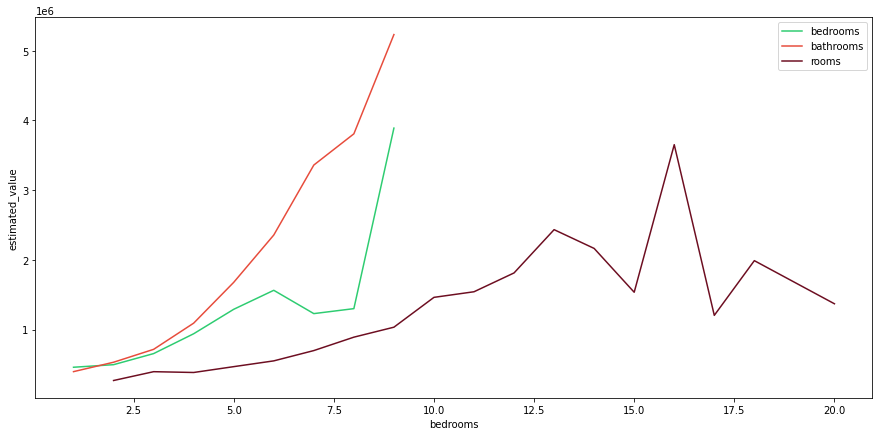

In [177]:
plt.figure(figsize=(15,7))
p1 = df[['bedrooms','estimated_value']].groupby('bedrooms').mean()
p2 = df[['bathrooms','estimated_value']].groupby('bathrooms').mean()
p3 = df[['rooms','estimated_value']].groupby('rooms').mean()
sns.lineplot(x=p1.index,y=p1['estimated_value'],color='#2ecc71',label='bedrooms')
sns.lineplot(x=p2.index,y=p2['estimated_value'],color='#e74C3C',label='bathrooms')
sns.lineplot(x=p3.index,y=p3['estimated_value'],color='#6D0E21',label='rooms')

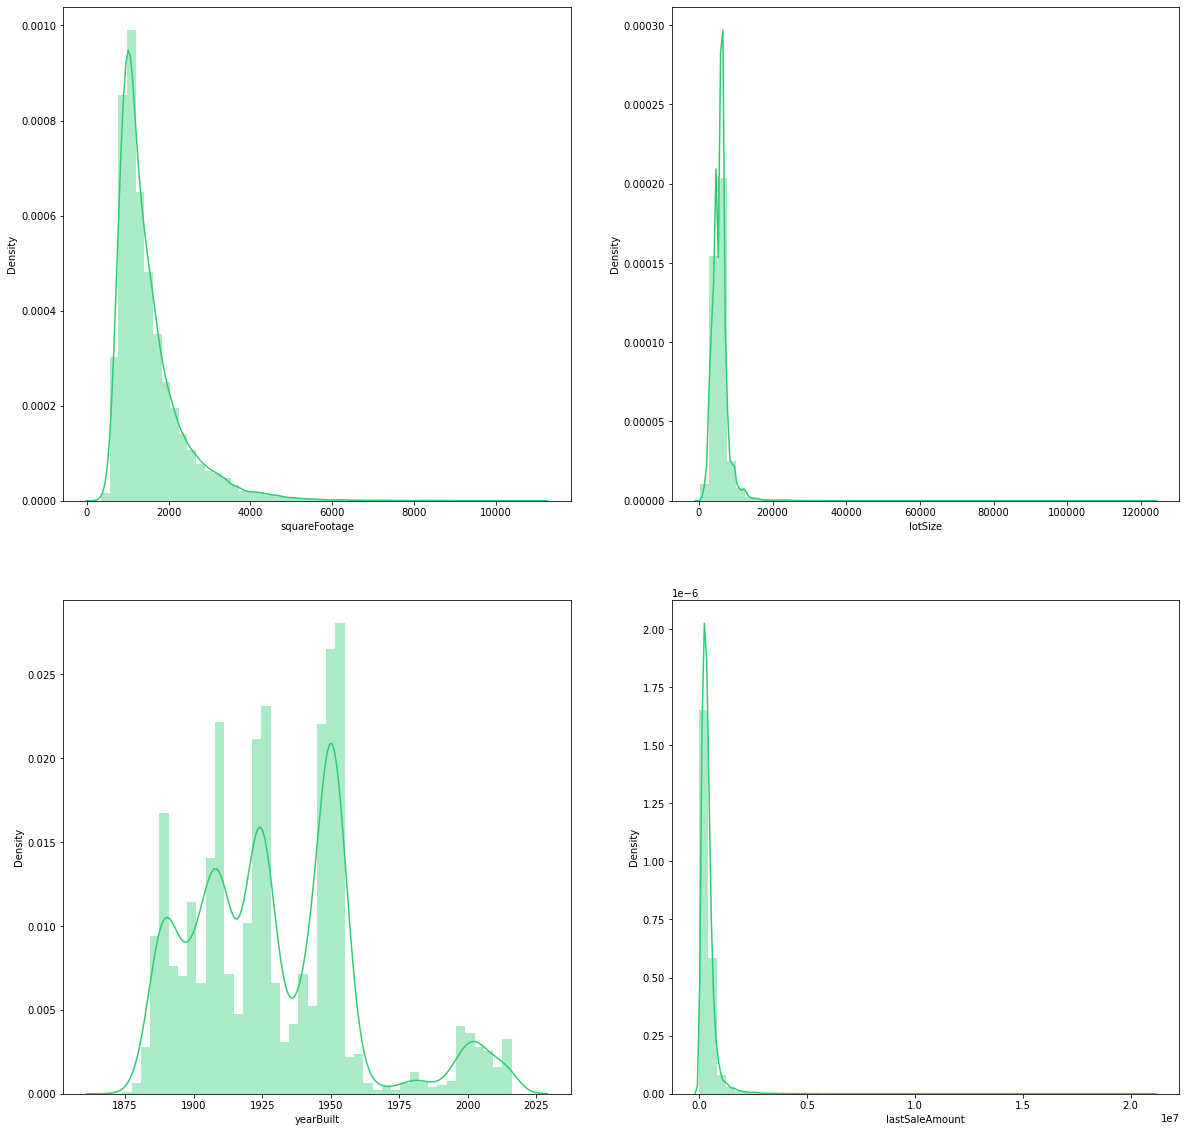

In [195]:
cont_feature = ['squareFootage','lotSize','yearBuilt','lastSaleAmount']
fig,axs = plt.subplots(ncols=2,nrows=2,figsize=(20,20))
for i, feature in enumerate(cont_feature):
    j=0
    if i>1:
        i = i-2
        j = 1
    sns.distplot(df[feature],color='#2ecc71',label=feature, ax=axs[j][i])

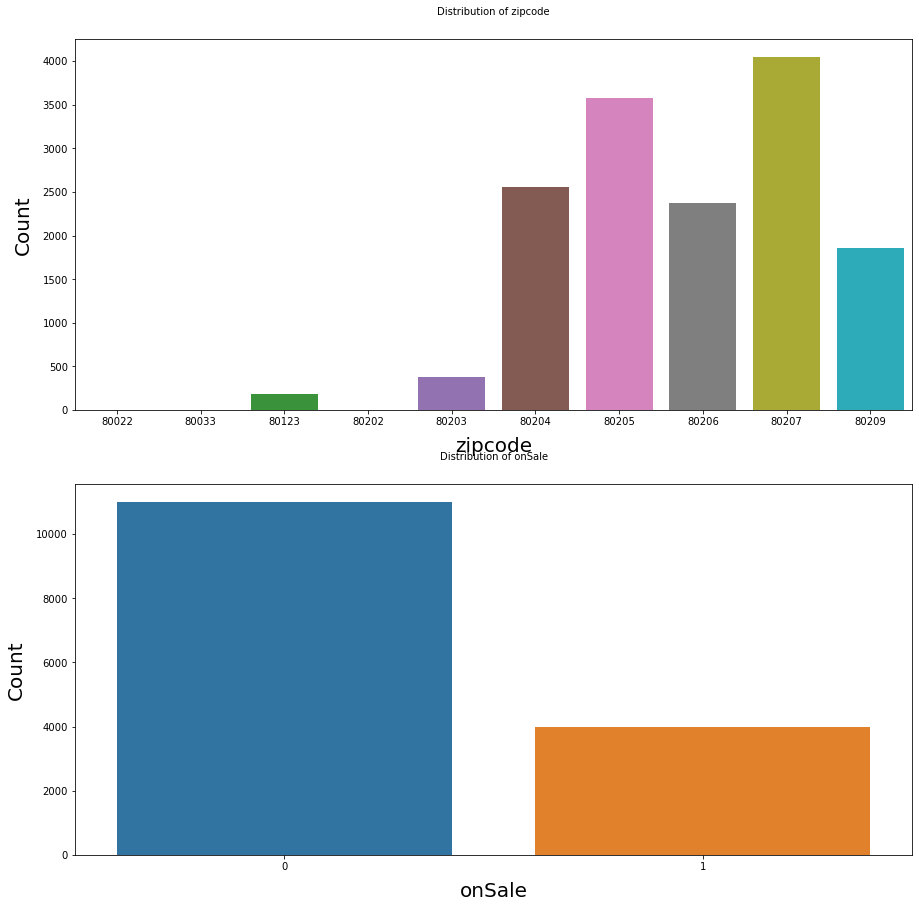

In [229]:
df.columns
cat_feature = ['zipcode','onSale']
fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(15,15))
#plt.subplots_adjust(right=1.5,top=1.25)
for i, feature in enumerate(cat_feature,1):
    plt.subplot(2,1,i)
    sns.countplot(df[feature])
    plt.xlabel('{}'.format(feature),size=20,labelpad=10)
    plt.ylabel('Count',size=20,labelpad=10)
    plt.tick_params(axis='x',labelsize=10)
    plt.tick_params(axis='y',labelsize=10)
    plt.title('Distribution of {}'.format(feature),size=10,y=1.05)

## 4. FEATURE ENGINEERING

What if we create a new feature that come from positively correlated with the prediction amounts columns?
* `each_sqft`: Can we realize which type of homes is higher evaluated than other homes? `estimated_value` divide `squareFootage`
* `up_each_sqft`: Through time, how much the value properties increase for 2 sales? (`lastSaleAmount` - `priorSaleAmount`) divide (`squareFootage` * `yearBuilt`) Which group strongly increase? Which group slightly increase?
* `type`: Can we classify type of properties depend on size of `squareFootage` and number of `rooms`?

In [361]:
df['each_sqft'] = df['estimated_value'] / df['squareFootage']
df['each_sqft'].describe()

count    14980.000000
mean       421.946676
std        121.811555
min         86.324316
25%        339.877940
50%        406.748494
75%        484.949033
max       3117.387922
Name: each_sqft, dtype: float64

In [362]:
df['up_each_sqft'] = (df['lastSaleAmount'] - df['priorSaleAmount']) / ((df['squareFootage'])*(2022-df['yearBuilt']))
df['up_each_sqft'].describe()

count    14980.000000
mean         1.075349
std          4.237675
min       -155.739344
25%          0.000000
50%          0.459716
75%          1.262487
max        186.160984
Name: up_each_sqft, dtype: float64

In [363]:
df['type'] = ''
for i in df.index:
    if df['rooms'][i] < 4:
        df['type'][i] = 'small'
    if (df['rooms'][i] >= 4) & (df['rooms'][i] < 8):
        df['type'][i] = 'medium'
    if (df['rooms'][i] >= 8) & (df['rooms'][i] < 11):
        df['type'][i] = 'big'
    if df['rooms'][i] >= 11:
        df['type'][i] = 'very big'

In [364]:
s = df['type'].value_counts()['small']/len(df['type'])*100
m = df['type'].value_counts()['medium']/len(df['type'])*100
b = df['type'].value_counts()['big']/len(df['type'])*100
v = df['type'].value_counts()['very big']/len(df['type'])*100

In [365]:
z_code = ['80207','80205','80204','80206','80209','80203','80123','80033','80022','80202']
df_plot = pd.DataFrame(columns=['zc','ty','per'])
for i in z_code:
    for j in ['small','medium','big','very big']:
        try:
            x = df[['zipcode','type']].value_counts()[i][j]/len(df[df.zipcode==i])*100
        except:
            x = 0
        df_plot = df_plot.append(pd.Series([i,j,x],index=['zc','ty','per']),ignore_index=True)
px.bar(df_plot,x='zc',y='per',color='ty',
      labels = {'zc':'zipcode','per':'percentage of house'},
       title = 'percentage type of house in each zipcode')

In [373]:
df1 = df.copy()
# clean out each square above 1500
df2 = df1[df1['each_sqft']<1500]
# clean out number of rooms 20
df3 = df2[df2['rooms']!=20]
# impotant feature
df4 = df3[['zipcode','bedrooms','bathrooms','rooms','squareFootage','lotSize','yearBuilt','onSale','period'
           ,'up_each_sqft','estimated_value']]
df4.head()

,zipcode,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,onSale,period,up_each_sqft,estimated_value
0,80022,3,2,6,1378,9968,2003,0,Medium,-3.464212,239753
1,80022,2,2,6,1653,6970,2004,1,VeryShort,0.000000,343963
2,80033,3,1,6,1882,23875,1917,1,VeryShort,0.000000,488840
3,80033,4,3,8,2400,11500,1956,0,Short,0.275694,494073
4,80123,3,4,8,2305,5600,1998,0,Short,3.012834,513676


## 5. BUILD MODEL

In [381]:
df5 = pd.get_dummies(df4.zipcode)
df6 = pd.get_dummies(df4.period)
df7 = pd.concat([df4,df5.drop('80022',axis='columns'),df6.drop('VeryShort',axis='columns')],axis='columns')

In [386]:
df8 = df7.drop(['zipcode','period'],axis='columns')
df8.head()

,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,onSale,up_each_sqft,estimated_value,80033,...,80203,80204,80205,80206,80207,80209,Long,Medium,Short,VeryLong
0,3,2,6,1378,9968,2003,0,-3.464212,239753,0,...,0,0,0,0,0,0,0,1,0,0
1,2,2,6,1653,6970,2004,1,0.000000,343963,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,6,1882,23875,1917,1,0.000000,488840,1,...,0,0,0,0,0,0,0,0,0,0
3,4,3,8,2400,11500,1956,0,0.275694,494073,1,...,0,0,0,0,0,0,0,0,1,0
4,3,4,8,2305,5600,1998,0,3.012834,513676,0,...,0,0,0,0,0,0,0,0,1,0


In [389]:
x = df8.drop('estimated_value',axis='columns')
y = df8.estimated_value

In [392]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [394]:
pca = PCA(0.98)
x_pca = pca.fit_transform(x_scaled)
pca.n_components_

17

In [397]:
algos = {
    'linear_regression': {'model': LinearRegression(),
                         'params': {'normalize':[True,False]}},
    'lasso': {'model':Lasso(),
             'params': {'alpha':[1,2],
                       'selection':['random','cyclic']}},
    'decision_tree': {'model':DecisionTreeRegressor(),
                     'params':{'criterion':['mse','friedman_mse'],
                              'splitter':['best','random']}}
}

In [406]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = []
for algo_name, config in algos.items():
    gs = GridSearchCV(config['model'],config['params'],cv=cv,return_train_score=False)
    gs.fit(x_scaled,y)
    scores.append({'model':algo_name,
                  'best_score': gs.best_score_,
                  'best_params': gs.best_params_})
pd.DataFrame(scores, columns=['model','best_score','best_params'])

,model,best_score,best_params
0,linear_regression,0.806066,{'normalize': True}
1,lasso,0.805997,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.783284,"{'criterion': 'mse', 'splitter': 'best'}"
